In [1]:
# import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
# import warnings

In [2]:
# Loading
df = pd.read_csv('TXN_DATA_CASA.txt',  skiprows=1,header=None, names=['TXN_DATE', 'AMOUNT', 'TXN_INITIATOR_BRANCH', 'ACC_HOST_BRANCH', 'SOURCE_ACC', 'INITIATOR', 'TRDID', 'CREATE_TIME', 'VERIFICATION_TIME', 'VALUE_DATE'])
df.head(3)

,TXN_DATE,AMOUNT,TXN_INITIATOR_BRANCH,ACC_HOST_BRANCH,SOURCE_ACC,INITIATOR,TRDID,CREATE_TIME,VERIFICATION_TIME,VALUE_DATE
0,1/2/2022,12000.0,3,3,178698,SYSTEM,120006,1/2/2022 3:05:03 PM,1/2/2022 3:05:03 PM,NaN
1,1/2/2022,115.0,63,63,99949,SYSTEM,220021,1/2/2022 3:05:04 PM,1/2/2022 3:05:04 PM,NaN
2,1/2/2022,2000.0,11,11,86624,nahida011,210003,1/2/2022 3:06:05 PM,1/2/2022 3:06:05 PM,NaN


# Exploratory Data Analysis (EDA)


In [3]:
# Summary statistics of the dataset
print(df.describe())

             AMOUNT  TXN_INITIATOR_BRANCH  ACC_HOST_BRANCH    SOURCE_ACC  \
count  1.954049e+06          1.954049e+06     1.954049e+06  1.954049e+06   
mean   2.667268e+05          1.337470e+02     4.315533e+01  1.920262e+05   
std    9.029367e+06          2.816360e+02     2.742390e+01  9.913730e+04   
min    1.000000e-02          1.000000e+00     2.000000e+00  1.000000e+00   
25%    1.199700e+03          2.100000e+01     2.000000e+01  1.059390e+05   
50%    1.000000e+04          4.500000e+01     4.000000e+01  1.991350e+05   
75%    5.000000e+04          7.300000e+01     6.400000e+01  2.797310e+05   
max    4.280000e+09          9.990000e+02     1.050000e+02  3.573050e+05   

              TRDID  
count  1.954049e+06  
mean   1.743248e+05  
std    5.026398e+04  
min    1.100030e+05  
25%    1.200060e+05  
50%    2.100030e+05  
75%    2.200210e+05  
max    2.300040e+05  


In [4]:
# Check for missing values
print(df.isnull().sum())

TXN_DATE                      0
AMOUNT                        0
TXN_INITIATOR_BRANCH          0
ACC_HOST_BRANCH               0
SOURCE_ACC                    0
INITIATOR                     0
TRDID                         0
CREATE_TIME                   0
VERIFICATION_TIME             0
VALUE_DATE              1460567
dtype: int64


In [5]:
cat_cols=df.select_dtypes(include=["object"]).columns
print(cat_cols)
num_cols=df.select_dtypes(include=["int","float"]).columns
print(f"numerical column {num_cols}")

Index(['TXN_DATE', 'INITIATOR', 'CREATE_TIME', 'VERIFICATION_TIME',
       'VALUE_DATE'],
      dtype='object')
numerical column Index(['AMOUNT', 'TXN_INITIATOR_BRANCH', 'ACC_HOST_BRANCH', 'SOURCE_ACC',
       'TRDID'],
      dtype='object')


In [6]:
print(len(df["TXN_INITIATOR_BRANCH"].unique()),df["TXN_INITIATOR_BRANCH"].unique())
print(len(df["ACC_HOST_BRANCH"].unique()),df["ACC_HOST_BRANCH"].unique())
print(len(df["SOURCE_ACC"].unique()),df["SOURCE_ACC"].unique())
print(len(df["TRDID"].unique()),df["TRDID"].unique())

106 [  3  63  11   2  55 102  35  57 105  62  49  33  53  46  76  94  96  92
  70  82  28  91  23  40  48  42  39  67  41   6   5   8  20  15  26  83
  29  43  37  81  78  25  98  27 100  10  21  79  12  99  75  50  88  66
  64  97  85  90   9  68  60  84  44  61  34  24  73  71  22  65  93  52
  32  87  54  72  45  95  38  36 999   7  14  77  74  30  56  19 104  16
  17  31  59  89  51  13 103  86  47  18   1  69  58   4  80 101]
104 [  3  63  11   2  55 102  35  57 105  62  49  33  53  67  76  46  94  96
  92  70   8  25  28  91  23  40  48  42  39  71  41   6   5  37  20  15
  26  83  29  43  81  78 100  98  27  10  60  21  79  12  99  75  50  88
  66  64  97  82  85  90   9  38  68  84  44  58  61  34  22  24  18  73
  65  93  54  36  32  87  72  45  95   4   7  14  56  77  74  69  30  52
  19  59 104  16  17  31  13  47  89  80 101  51 103  86]
142710 [178698  99949  86624 ... 355491 355501 355490]
12 [120006 220021 210003 230004 220089 110003 120089 120001 230002 220001
 130002 2

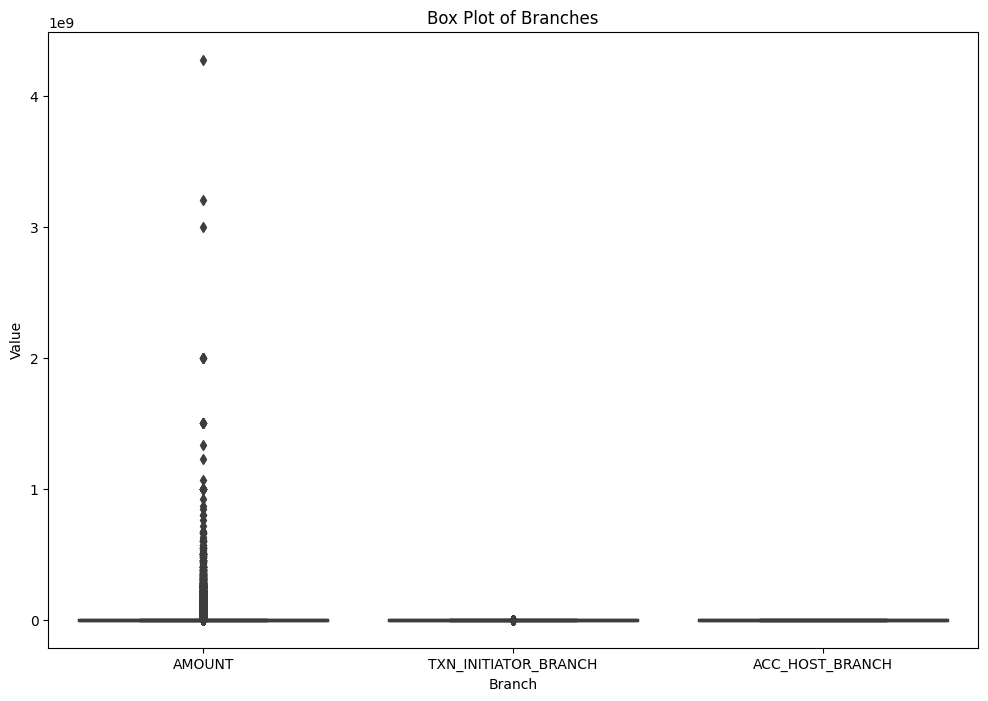

In [7]:
# Plot box plots for other numerical features with adjusted box size
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[['AMOUNT','TXN_INITIATOR_BRANCH', 'ACC_HOST_BRANCH']], linewidth=2.5)
plt.title('Box Plot of Branches')
plt.xlabel('Branch')
plt.ylabel('Value')
plt.show()


#### Handling numerical cols





In [8]:
# for 'TXN_INITIATOR_BRANCH'
initiator_freq = df['TXN_INITIATOR_BRANCH'].value_counts(normalize=True)
# Map 
initiator_freq_mapping = initiator_freq.to_dict()
# Replace 
df['TXN_INITIATOR_BRANCH_FREQ'] = df['TXN_INITIATOR_BRANCH'].map(initiator_freq_mapping)

# for 'ACC_HOST_BRANCH'
acc_host_freq = df['ACC_HOST_BRANCH'].value_counts(normalize=True)
acc_host_freq_mapping = acc_host_freq.to_dict()
df['ACC_HOST_BRANCH_FREQ'] = df['ACC_HOST_BRANCH'].map(acc_host_freq_mapping)

# for SOURCE_ACC
source_acc_freq = df['SOURCE_ACC'].value_counts(normalize=True)
source_acc_freq_mapping = source_acc_freq.to_dict()
df['SOURCE_ACC_FREQ'] = df['SOURCE_ACC'].map(source_acc_freq_mapping)

# Drop the original columns
df.drop(columns=['TXN_INITIATOR_BRANCH', 'ACC_HOST_BRANCH','SOURCE_ACC'], inplace=True)

In [9]:
#label encoding for TRID
label_encoder = LabelEncoder()
df['TRDID'] = label_encoder.fit_transform(df['TRDID'])

# Handling object cols

In [10]:
df['TXN_DATE'] = pd.to_datetime(df['TXN_DATE'])
df['CREATE_TIME'] = pd.to_datetime(df['CREATE_TIME'])
df['VERIFICATION_TIME'] = pd.to_datetime(df['VERIFICATION_TIME'])
df['VALUE_DATE'] = pd.to_datetime(df['VALUE_DATE'])


C:\Users\klikh\AppData\Local\Temp\ipykernel_11040\2392748587.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CREATE_TIME'] = pd.to_datetime(df['CREATE_TIME'])
C:\Users\klikh\AppData\Local\Temp\ipykernel_11040\2392748587.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['VERIFICATION_TIME'] = pd.to_datetime(df['VERIFICATION_TIME'])
C:\Users\klikh\AppData\Local\Temp\ipykernel_11040\2392748587.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['VALUE_DATE'] = pd.to_datetime(df['VALUE_DATE'])


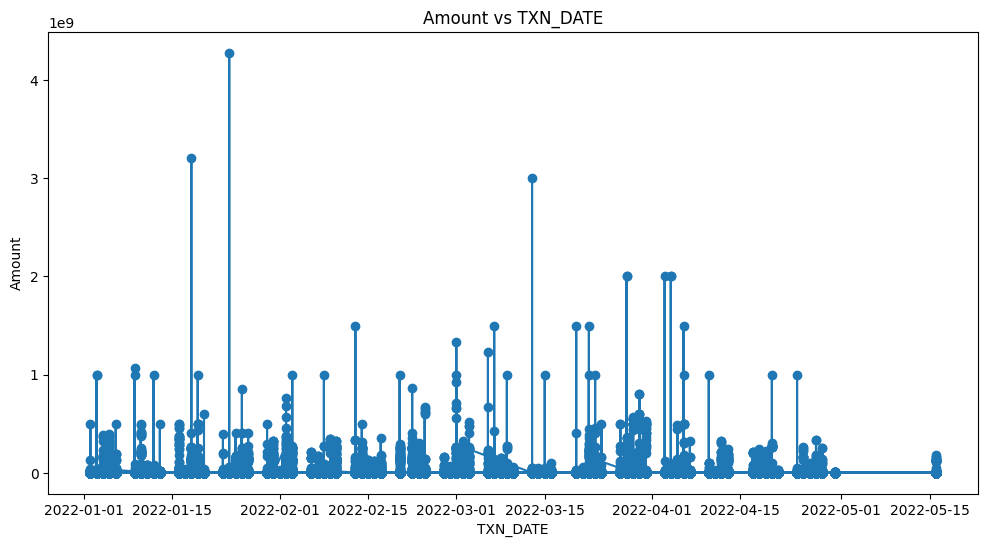

In [11]:
# Plot time series for datetime features
plt.figure(figsize=(12, 6))
plt.plot(df['TXN_DATE'], df['AMOUNT'], marker='o', linestyle='-')
plt.title('Amount vs TXN_DATE')
plt.xlabel('TXN_DATE')
plt.ylabel('Amount')
plt.show()

In [12]:
# frequency encoding for initiator

initiator_freq = df['INITIATOR'].value_counts(normalize=True)

# Map 
initiator_freq_mapping = initiator_freq.to_dict()

# Replace 
df['INITIATOR_FREQ'] = df['INITIATOR'].map(initiator_freq_mapping)
#drop original 
df.drop(columns=['INITIATOR'], inplace=True)


In [13]:

# Sort by 'VALUE_DATE' 
df = df.sort_values('VALUE_DATE')

# linear interpolation 
df['VALUE_DATE'] = df['VALUE_DATE'].interpolate(method='linear')

# Check 
print("Number of missing values after interpolation:", df['VALUE_DATE'].isnull().sum())


Number of missing values after interpolation: 0


In [14]:
df.head(5)

,TXN_DATE,AMOUNT,TRDID,CREATE_TIME,VERIFICATION_TIME,VALUE_DATE,TXN_INITIATOR_BRANCH_FREQ,ACC_HOST_BRANCH_FREQ,SOURCE_ACC_FREQ,INITIATOR_FREQ
5689,2022-01-02,20.0,8,2021-12-31 15:17:59,2021-12-31 15:17:59,2021-12-31 00:00:00,0.028786,0.042373,0.000063,0.010399
25893,2022-01-02,1530.0,8,2021-12-31 15:20:36,2021-12-31 15:20:36,2021-12-31 15:09:13,0.004399,0.004927,0.000056,0.000020
25894,2022-01-02,2000.0,8,2021-12-31 15:21:16,2021-12-31 15:21:16,2021-12-31 15:09:52,0.007295,0.008217,0.000017,0.000010
16740,2022-01-02,1000.0,8,2021-12-31 15:32:48,2021-12-31 15:32:48,2021-12-31 15:21:24,0.008228,0.008871,0.000036,0.000014
16741,2022-01-02,920.0,8,2021-12-31 15:34:01,2021-12-31 15:34:01,2021-12-31 15:22:38,0.014908,0.017172,0.000014,0.000006


In [15]:
df.isnull().sum()

TXN_DATE                     0
AMOUNT                       0
TRDID                        0
CREATE_TIME                  0
VERIFICATION_TIME            0
VALUE_DATE                   0
TXN_INITIATOR_BRANCH_FREQ    0
ACC_HOST_BRANCH_FREQ         0
SOURCE_ACC_FREQ              0
INITIATOR_FREQ               0
dtype: int64

# Feature Engineering:

In [16]:
# Extract datetime features
df['TXN_MONTH'] = df['TXN_DATE'].dt.month
df['TXN_DAY'] = df['TXN_DATE'].dt.day
df['CREATE_HOUR'] = df['CREATE_TIME'].dt.hour
df['VERIFICATION_MONTH'] = df['VERIFICATION_TIME'].dt.month
df['VALUE_MONTH'] = df['VALUE_DATE'].dt.month
df['TXN_DAY_OF_WEEK'] = df['TXN_DATE'].dt.dayofweek
df['VERIFICATION_DAY_OF_WEEK'] = df['VERIFICATION_TIME'].dt.dayofweek
# Calculate time differences
df['CREATE_VERIFICATION_TIMEDIFF'] = (df['VERIFICATION_TIME'] - df['CREATE_TIME']).dt.seconds
df['VERIFICATION_VALUE_TIMEDIFF'] = (df['VALUE_DATE'] - df['VERIFICATION_TIME']).dt.seconds
# Create binary features
df['TXN_END_OF_MONTH'] = (df['TXN_DATE'].dt.is_month_end).astype(int)
df['TXN_WEEKEND'] = (df['TXN_DATE'].dt.dayofweek >= 5).astype(int)

# Scaling and Dropping

In [18]:
scaler = MinMaxScaler()
df[['AMOUNT','CREATE_VERIFICATION_TIMEDIFF','VERIFICATION_VALUE_TIMEDIFF']] = scaler.fit_transform(df[['AMOUNT','CREATE_VERIFICATION_TIMEDIFF','VERIFICATION_VALUE_TIMEDIFF']])


In [19]:
df.drop(columns=['TXN_DATE', 'CREATE_TIME', 'VERIFICATION_TIME', 'VALUE_DATE'], inplace=True)


In [20]:
df.head(10)

,AMOUNT,TRDID,TXN_INITIATOR_BRANCH_FREQ,ACC_HOST_BRANCH_FREQ,SOURCE_ACC_FREQ,INITIATOR_FREQ,TXN_MONTH,TXN_DAY,CREATE_HOUR,VERIFICATION_MONTH,VALUE_MONTH,TXN_DAY_OF_WEEK,VERIFICATION_DAY_OF_WEEK,CREATE_VERIFICATION_TIMEDIFF,VERIFICATION_VALUE_TIMEDIFF,TXN_END_OF_MONTH,TXN_WEEKEND
5689,4.670561e-09,8,0.028786,0.042373,0.000063,0.010399,1,2,15,12,12,6,4,0.0,0.362528,0,1
25893,3.574743e-07,8,0.004399,0.004927,0.000056,0.000020,1,2,15,12,12,6,4,0.0,0.992141,0,1
25894,4.672874e-07,8,0.007295,0.008217,0.000017,0.000010,1,2,15,12,12,6,4,0.0,0.992129,0,1
16740,2.336425e-07,8,0.008228,0.008871,0.000036,0.000014,1,2,15,12,12,6,4,0.0,0.992129,0,1
16741,2.149509e-07,8,0.014908,0.017172,0.000014,0.000006,1,2,15,12,12,6,4,0.0,0.992141,0,1
25898,1.168222e-06,8,0.011078,0.013318,0.000022,0.000010,1,2,15,12,12,6,4,0.0,0.992129,0,1
16742,4.672874e-07,8,0.007237,0.006999,0.000040,0.000016,1,2,15,12,12,6,4,0.0,0.992129,0,1
27702,1.168201e-07,8,0.028786,0.042373,0.000045,0.000020,1,2,15,12,12,6,4,0.0,0.992129,0,1
23219,2.371472e-07,9,0.095025,0.010200,0.000013,0.091465,1,2,12,1,1,6,5,0.0,0.470705,0,1
23218,2.339951e-06,9,0.095025,0.003350,0.000022,0.091465,1,2,12,1,1,6,5,0.0,0.471075,0,1


In [21]:
df.isnull().sum()

AMOUNT                          0
TRDID                           0
TXN_INITIATOR_BRANCH_FREQ       0
ACC_HOST_BRANCH_FREQ            0
SOURCE_ACC_FREQ                 0
INITIATOR_FREQ                  0
TXN_MONTH                       0
TXN_DAY                         0
CREATE_HOUR                     0
VERIFICATION_MONTH              0
VALUE_MONTH                     0
TXN_DAY_OF_WEEK                 0
VERIFICATION_DAY_OF_WEEK        0
CREATE_VERIFICATION_TIMEDIFF    0
VERIFICATION_VALUE_TIMEDIFF     0
TXN_END_OF_MONTH                0
TXN_WEEKEND                     0
dtype: int64

In [22]:
df.shape

(1954049, 17)

# Isolation Forest

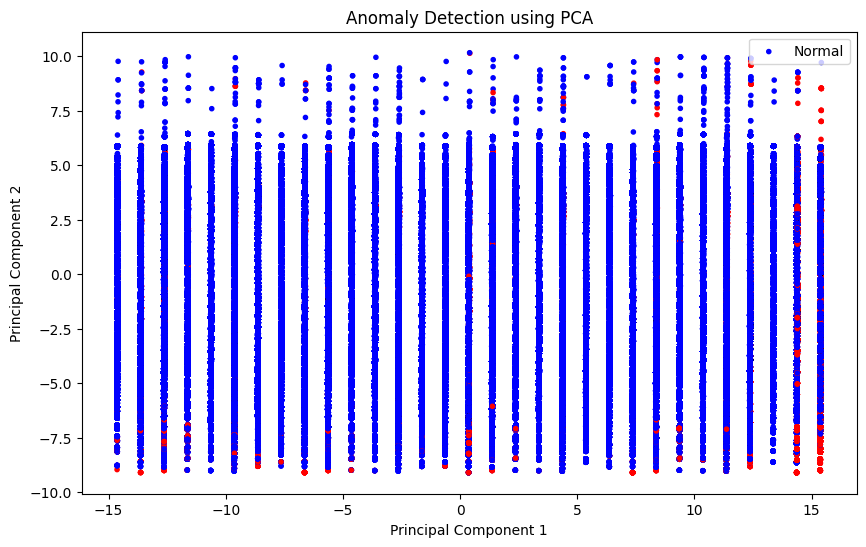

Number of anomalies: 29311


In [23]:

# Apply Isolation Forest
isolation_forest = IsolationForest(contamination=0.015, random_state=42)
y_pred= isolation_forest.fit_predict(df)


# bianry labels (-1 and 1)
anomaly_mask = (y_pred == -1)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)

# Plotting anomalies
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.where(anomaly_mask, 'red', 'blue'), marker='.')
plt.title('Anomaly Detection using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(['Normal', 'Anomaly'], loc='upper right')
plt.show()

# Print number of anomalies
num_anomalies = np.sum(anomaly_mask)
print("Number of anomalies:", num_anomalies)

In [24]:
# Print number of anomalies
print(f"{num_anomalies} anomaly cases out of {len(df)} cases")
print(f"percentage of anomaly cases is {(num_anomalies/len(df))*100} %")

29311 anomaly cases out of 1954049 cases
percentage of anomaly cases is 1.5000135615841772 %


# Local Outlier Factor


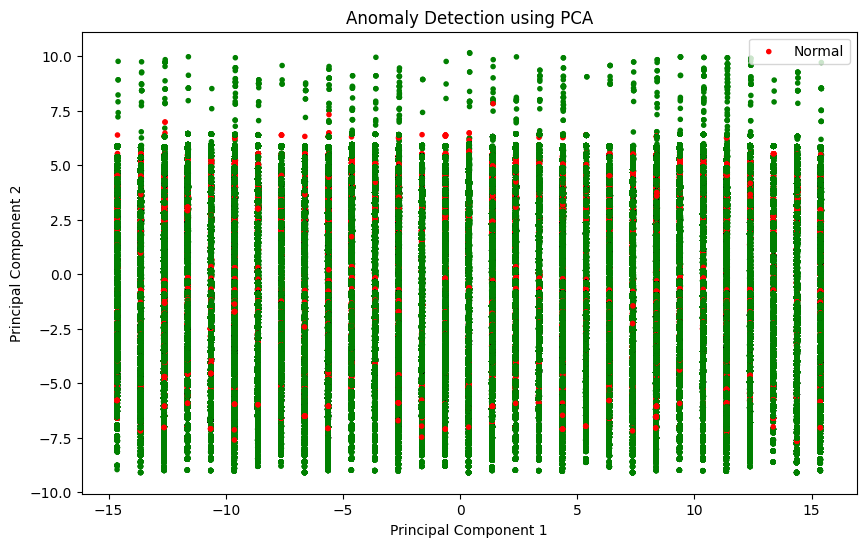

In [35]:
# Apply Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.01)
y_pred_lof = lof.fit_predict(df)

# Anomalies are labeled as -1 and normal instances as 1, convert to binary labels
anomaly_mask_lof = (y_pred_lof == -1)
# Dimensionality reduction using PCA
pca_lof = PCA(n_components=2)
X_pca_lof = pca_lof.fit_transform(df)

# Plotting anomalies
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_lof[:, 0], X_pca_lof[:, 1], c=np.where(anomaly_mask_lof, 'red', 'green'), marker='.')
plt.title('Anomaly Detection using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(['Normal', 'Anomaly'], loc='upper right')
plt.show()


In [36]:
# Print number of anomalies
num_anomalies_lof = np.sum(anomaly_mask_lof)
print("Number of anomalies:", num_anomalies_lof)
print(f"{num_anomalies_lof} anomalies out of {len(df)} datapoints which is {(num_anomalies_lof/len(df))*100}%")

Number of anomalies: 19541
19541 anomalies out of 1954049 datapoints which is 1.0000260996525674%


# Auto Encoders

In [37]:
# Define the autoencoder model
autoencoder = tf.keras.models.Sequential([
    
    # Encoding layers
    layers.Dense(64, activation='relu', input_shape=(df.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),

    # Decoding layers
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(df.shape[1], activation='relu')
])

# Compile 
autoencoder.compile(optimizer="adam", 
                    loss="mse")

# print overview 
autoencoder.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1152      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 17)                1105      
                                                                 
Total params: 7521 (29.38 KB)
Trainable params: 7521 (

In [38]:
early_stop =keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
)

In [39]:
history = autoencoder.fit(
    df, df,
    shuffle=True,
    epochs=20,
    batch_size=64,
    callbacks=early_stop,
   verbose=2
)

Epoch 1/20
30533/30533 - 37s - loss: 0.0575 - 37s/epoch - 1ms/step
Epoch 2/20
30533/30533 - 34s - loss: 0.0206 - 34s/epoch - 1ms/step
Epoch 3/20
30533/30533 - 36s - loss: 0.0205 - 36s/epoch - 1ms/step
Epoch 4/20
30533/30533 - 37s - loss: 0.0205 - 37s/epoch - 1ms/step
Epoch 5/20
30533/30533 - 36s - loss: 0.0204 - 36s/epoch - 1ms/step
Epoch 6/20
30533/30533 - 36s - loss: 0.0204 - 36s/epoch - 1ms/step
Epoch 7/20
30533/30533 - 38s - loss: 0.0204 - 38s/epoch - 1ms/step
Epoch 8/20
30533/30533 - 34s - loss: 0.0203 - 34s/epoch - 1ms/step
Epoch 9/20
30533/30533 - 35s - loss: 0.0203 - 35s/epoch - 1ms/step
Epoch 10/20
30533/30533 - 35s - loss: 0.0203 - 35s/epoch - 1ms/step
Epoch 11/20
30533/30533 - 35s - loss: 0.0203 - 35s/epoch - 1ms/step
Epoch 12/20
30533/30533 - 45s - loss: 0.0203 - 45s/epoch - 1ms/step
Epoch 13/20
30533/30533 - 38s - loss: 0.0203 - 38s/epoch - 1ms/step
Epoch 14/20
30533/30533 - 34s - loss: 0.0203 - 34s/epoch - 1ms/step
Epoch 15/20
30533/30533 - 35s - loss: 0.0202 - 35s/epoch 

61065/61065 [==============================] - 63s 1ms/step


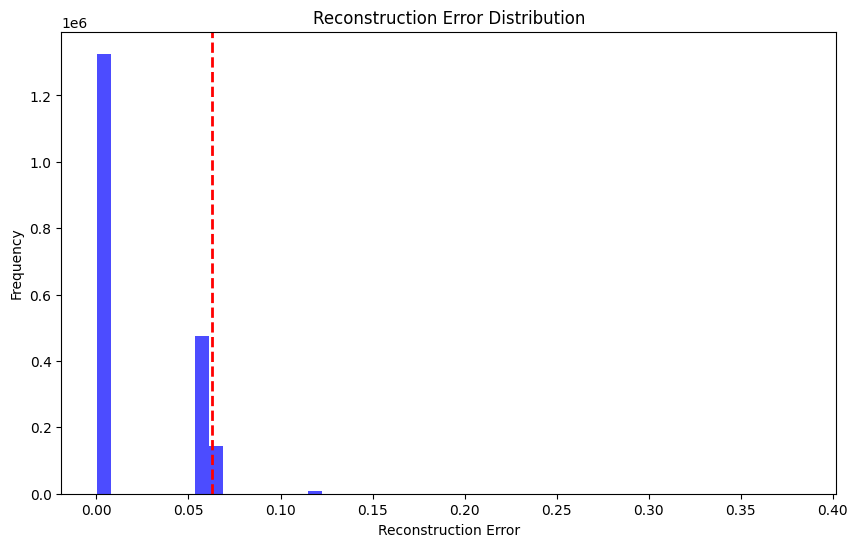

Number of anomalies: 39081


In [40]:
# reconstruction
reconstructed_data = autoencoder.predict(df)
# reconstruction error 
mse = np.mean(np.square(df - reconstructed_data), axis=1)

# threshold 
threshold = np.percentile(mse, 98)

# Identify anomalies 
anomaly_mask_ae = (mse > threshold)

# Plotting anomalies
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, color='blue', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print number of anomalies
num_anomalies_ae = np.sum(anomaly_mask_ae)
print("Number of anomalies:", num_anomalies_ae)

In [34]:
# Print number of anomalies
print(f"{num_anomalies_ae} anomalies out of {len(df)} datapoints which is {(num_anomalies_ae/len(df))*100}%")

39081 anomalies out of 1954049 datapoints which is 2.0000010235157872%
